# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проекту
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [59]:
geo_comment = pd.read_excel("geo_comment.xlsx")
geo_comment.head()

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [60]:
geo = pd.read_excel("geo.xlsx")
geo.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


Посмотрим на данные.

In [61]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     108806 non-null  int64  
 1   x              108806 non-null  float64
 2   y              108806 non-null  float64
 3   comment_class  108806 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


In [62]:
geo.describe()

,Unnamed: 0,x,y,comment_class
count,108806.000000,108806.000000,108806.000000,108806.000000
mean,54402.500000,37.567532,55.766346,-0.748929
std,31409.731032,0.121996,0.069622,0.662653
min,0.000000,37.148813,55.496939,-1.000000
25%,27201.250000,37.454528,55.729797,-1.000000
50%,54402.500000,37.559640,55.764734,-1.000000
75%,81603.750000,37.684784,55.806869,-1.000000
max,108805.000000,37.931228,55.994174,1.000000


In [63]:
geo["comment_class"].value_counts()

-1    95147
 1    13659
Name: comment_class, dtype: int64

Пропусков нет. Значения x и y адекватные, comment_class соотвестствует описанию.

In [64]:
len(geo[geo.index != geo["Unnamed: 0"]])

0

Unnamed: 0 - индекс. Не понадобится.

Для кластеризации используем алгоритм KMeans.

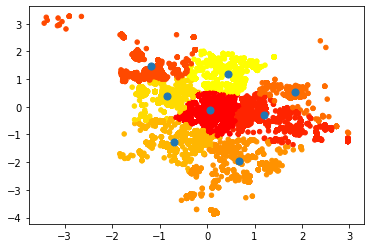

Кол-во кластеров: 8.


In [65]:
def show_clusters(data, n_clusters=None):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    if n_clusters is None:
        algorithm = KMeans()
    else:
        algorithm = KMeans(n_clusters=n_clusters)
    clusters = algorithm.fit_predict(data_scaled)
    plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters, cmap="autumn", s=20)
    centers = algorithm.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], s=50)
    plt.show()
    print(f"Кол-во кластеров: {len(list(set(clusters)))}.")
    

X = geo[["x", "y"]]
show_clusters(X)

Отберем точки с голосованием "за" и выполним кластеризацию.

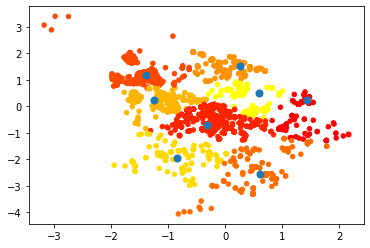

Кол-во кластеров: 8.


In [66]:
X_yes = geo[geo["comment_class"] == 1][["x", "y"]]
show_clusters(X_yes)

Отберем точки с голосованием "против" и выполним кластеризацию.

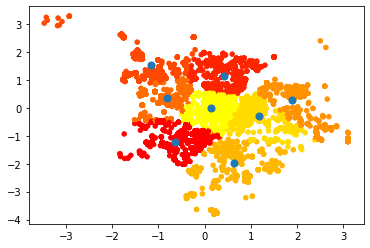

Кол-во кластеров: 8.


In [67]:
X_no = geo[geo["comment_class"] == -1][["x", "y"]]
show_clusters(X_no)

Подберем оптимальное кол-во кластеров для всех голосов.

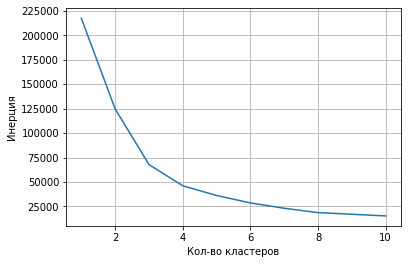

In [68]:
def get_inertia(data, count):
    k_inertia = []
    ks = range(1, count + 1)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(data_scaled)
        k_inertia.append(clf_kmeans.inertia_)

    plt.plot(ks, k_inertia)
    plt.xlabel("Кол-во кластеров")
    plt.ylabel("Инерция")
    plt.grid()
    return k_inertia

count = 10
k_inertia = get_inertia(X, count)

Расчитаем оптимальное кол-во кластеров.

Оптимальное кол-во кластеров: 8.


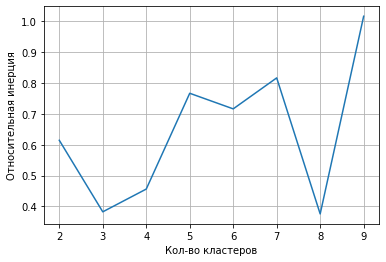

In [69]:
def get_cluters_optimum(k_inertia, count):
    ks = range(1, count + 1)
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    plt.plot(ks[1:-1], diff_r)
    plt.xlabel("Кол-во кластеров")
    plt.ylabel("Относительная инерция")
    plt.grid()
    k_opt = ks[np.argmin(diff_r) + 1]
    print(f"Оптимальное кол-во кластеров: {k_opt}.")
    return k_opt


k_opt = get_cluters_optimum(k_inertia, count)

Построим разбиение с оптимальным кол-вом кластеров.

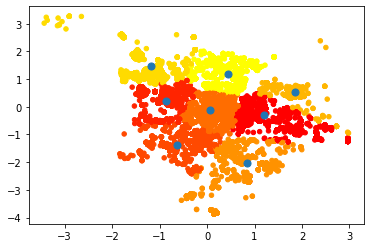

Кол-во кластеров: 8.


In [70]:
show_clusters(X, k_opt)

Подберем оптимальное кол-во кластеров для проголосовавших "за".

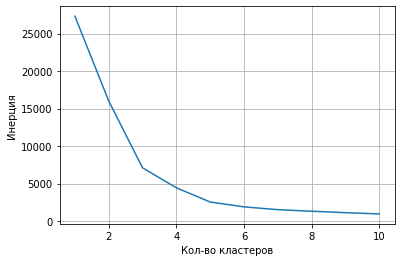

In [71]:
k_inertia_yes = get_inertia(X_yes, count)

Расчитаем оптимальное кол-во кластеров.

Оптимальное кол-во кластеров: 3.


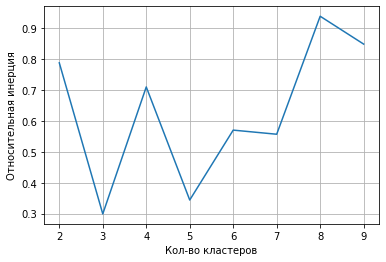

In [72]:
k_opt_yes = get_cluters_optimum(k_inertia_yes, count)

Построим разбиение с оптимальным кол-вом кластеров.

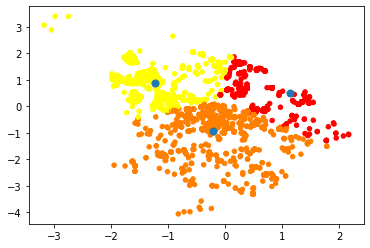

Кол-во кластеров: 3.


In [73]:
show_clusters(X_yes, k_opt_yes)

Подберем оптимальное кол-во кластеров для проголосовавших "против".

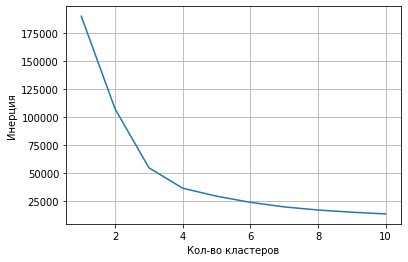

In [74]:
k_inertia_no = get_inertia(X_no, count)

Расчитаем оптимальное кол-во кластеров.

Оптимальное кол-во кластеров: 3.


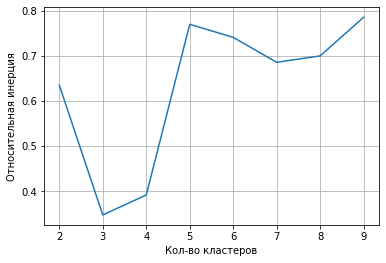

In [75]:
k_opt_no = get_cluters_optimum(k_inertia_no, count)

Построим разбиение с оптимальным кол-вом кластеров.

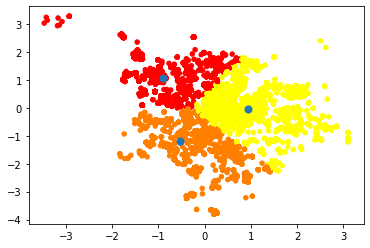

Кол-во кластеров: 3.


In [76]:
show_clusters(X_no, k_opt_no)

Найдем наиболее активные регионы по голосованию. Для этого сгруппируем по x и y.

In [77]:
X_gr = geo_comment[["x","y","multiplier"]].groupby(["x", "y"]).sum().reset_index()
X_gr

,x,y,multiplier
0,37.148813,55.976806,1
1,37.154158,55.991606,1
2,37.156817,55.984043,1
3,37.182887,55.970403,1
4,37.184566,55.989688,1
...,...,...,...
2537,37.900039,55.717239,25
2538,37.928893,55.702531,1
2539,37.929566,55.679423,51
2540,37.929728,55.686822,21


Кластеризуем и выведем активность по районам (более темный - выше активность).

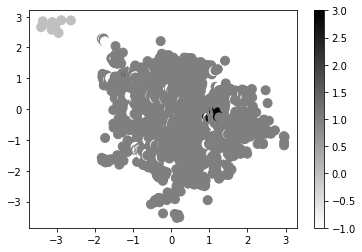

Кол-во кластеров: 5.


In [78]:
def show_clusters_dbscan(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    algorithm = DBSCAN()
    clusters = algorithm.fit_predict(data_scaled)
    
    plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=clusters, cmap="gray_r", s=80)
    plt.colorbar()
    plt.show()
    print(f"Кол-во кластеров: {len(list(set(clusters)))}.")


show_clusters_dbscan(X_gr)